In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from collections import Counter
import matplotlib
from matplotlib.colors import ListedColormap

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(20,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def save_fig(ax, folder, suffix, format="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + "." + format)
    fig.clear()

In [11]:
df_paper = pd.DataFrame()

for experiment in ["server", "satellite"]:
    for run in ["1", "2", "3"]:

        #actual_start = max(df1["send_time"].min(), df2["send_time"].min(), df3["send_time"].min())
        #actual_end = min(df1["send_time"].max(), df2["send_time"].max(), df3["send_time"].max())

        #actual_length = actual_end - actual_start
        #print(actual_length/1e9)

        required_length = 10 * 60 * 1e9
        #cutoff = (actual_length - required_length) / 2

        expected_path = os.path.join("..", "results", experiment, run, "tracker.csv" )

        expected_df = pd.read_csv(expected_path)

        min_t = 0
        if experiment == "server":
            min_t = expected_df[expected_df["path1dist"] > 23.0]["t"].min()
        elif experiment == "satellite":
            min_t = expected_df[expected_df["path2dist"] > 2.0]["t"].min()


        start = min_t# + 10 * 1e9
        end = start + required_length


        expected_df["t"] = expected_df["t"] - start

        # cut off some stuff

        expected_df = expected_df[(0 <= expected_df["t"]) & (expected_df["t"] <= required_length)]


        for client in ["1", "2", "3"]:
            for other_client in ["1", "2", "3"]:
                if client == other_client:
                    continue

                # create dataframe new dataframe with counts per latency per run per threshold
                df_run = expected_df[["path" + client + "dist", "path" + other_client + "dist", "t"]].copy()
                df_run["latency"] = expected_df["path" + client + "dist"] + expected_df["path" + other_client + "dist"] + 1.37
                df_run = df_run[["latency", "t"]]


                # transform index into column and add other columns needed for the figure
                df_run.reset_index(inplace=True, drop=True)
                df_run.insert(0, "Experiment", experiment)
                df_run.insert(1, "Run", run)
                df_run.insert(2, "Path", client + "-" + str(other_client))
                df_run.insert(3, "Type", "Expected")

                df_run["t2"] = pd.to_datetime(df_run["t"])
                df_run.sort_values(by=["t2"], inplace=True)
                df_run["latency_r"] = df_run.rolling('1s', min_periods=1, on="t2").median()["latency"]
                df_run["latency_r_log10"] = np.log10(df_run["latency_r"])

                # set column names
                df_run.columns = ["Experiment", "Run", "Path", "Type", "Latency", "t", "t2", "Latency_Rolling", "Latency_Rolling_log10"]
                # calculate distribution
                df_run.sort_values(by="t", ascending=True, inplace=True)
                # add to result df
                df_paper = df_paper.append(df_run)

            # relevant file is in ../results/[experiment]/[run]/[client].csv
            df = pd.read_csv(os.path.join("..", "results", experiment, run, client + ".csv" ))
            other_clients = df["id"].unique()

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            #df["send_time"] = df["send_time"] - min_t
            #df["recv_time"] = df["recv_time"] - min_t

            # cut off some stuff

            df = df[(start <= df["send_time"]) & (df["send_time"] <= end)]
            #df = df[df["latency"] < 500]

            min_t_now = df["send_time"].min()
            df["send_time"] = df["send_time"] - min_t_now
            df["recv_time"] = df["recv_time"] - min_t_now

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            for other in other_clients:

                df_run = df[(df["id"] == other)][["latency", "send_time"]].copy()
                # transform index into column and add other columns needed for the figure

                df_run.reset_index(inplace=True, drop=True)
                df_run.insert(0, "Experiment", experiment)
                df_run.insert(1, "Run", run)
                df_run.insert(2, "Path", str(other) + "-" + client)
                df_run.insert(3, "Type", "Measured")

                df_run["t2"] = pd.to_datetime(df_run["send_time"])
                df_run.sort_values(by=["t2"], inplace=True)
                df_run["latency_r"] = df_run.rolling('1s', min_periods=1, on="t2").median()["latency"]
                df_run["latency_r_log10"] = np.log10(df_run["latency_r"])

                # set column names
                df_run.columns = ["Experiment", "Run", "Path", "Type", "Latency", "t", "t2", "Latency_Rolling", "Latency_Rolling_log10"]
                # calculate distribution
                df_run.sort_values(by="t2", ascending=True, inplace=True)
                # add to result df
                df_paper = df_paper.append(df_run)

# convert to seconds
df_paper["t"] = df_paper["t"] / 1e9
df_paper

647.660389888
597.411473408
648.358293504
597.999697664
648.358293504
597.999697664
647.854826752
597.69797632
645.08589056
594.79465216
647.972277248
597.69797632
651.542534656
599.996351232
646.372124416
599.993561088
651.542534656
599.996351232
657.630340864
599.991361536
657.76747904
599.984559616
651.335744768
599.990734848
656.747031552
599.994708224
654.019089152
599.983681536
656.659459328
599.994708224
653.648069888
599.99475968
658.515869184
599.977052416
658.196393472
599.998304


,Experiment,Run,Path,Type,Latency,t,t2,Latency_Rolling,Latency_Rolling_log10
0,server,1,1-2,Expected,46.970912,0.000000,1970-01-01 00:00:00.000000000,46.970912,1.671829
1,server,1,1-2,Expected,46.943503,4.982369,1970-01-01 00:00:04.982369037,46.943503,1.671575
2,server,1,1-2,Expected,46.932888,9.878033,1970-01-01 00:00:09.878032514,46.932888,1.671477
3,server,1,1-2,Expected,46.925132,14.969802,1970-01-01 00:00:14.969802325,46.925132,1.671405
4,server,1,1-2,Expected,46.927694,20.036131,1970-01-01 00:00:20.036131177,46.927694,1.671429
...,...,...,...,...,...,...,...,...,...
193875,satellite,3,2-3,Measured,14.920000,599.995718,1970-01-01 00:09:59.995717632,14.220000,1.152900
193876,satellite,3,2-3,Measured,14.160000,599.996481,1970-01-01 00:09:59.996480768,14.215000,1.152747
193877,satellite,3,2-3,Measured,13.660000,599.996983,1970-01-01 00:09:59.996982528,14.210000,1.152594
193878,satellite,3,2-3,Measured,13.250000,599.997405,1970-01-01 00:09:59.997405184,14.190000,1.151982


In [12]:
df_paper.sort_values(by=["Experiment", "t"], inplace=True)
df_paper.reset_index(inplace=True, drop=True) # optionally reset index
df_paper

,Experiment,Run,Path,Type,Latency,t,t2,Latency_Rolling,Latency_Rolling_log10
0,satellite,1,1-2,Expected,7.608423,0.000000,1970-01-01 00:00:00.000000000,7.608423,0.881295
1,satellite,1,1-3,Expected,9.817396,0.000000,1970-01-01 00:00:00.000000000,9.817396,0.991996
2,satellite,1,2-1,Measured,7.940000,0.000000,1970-01-01 00:00:00.000000000,7.940000,0.899821
3,satellite,1,2-1,Expected,7.608423,0.000000,1970-01-01 00:00:00.000000000,7.608423,0.881295
4,satellite,1,2-3,Expected,7.630685,0.000000,1970-01-01 00:00:00.000000000,7.630685,0.882563
...,...,...,...,...,...,...,...,...,...
6982683,server,3,2-3,Measured,42.730000,599.994235,1970-01-01 00:09:59.994234624,42.630000,1.629715
6982684,server,3,2-1,Measured,41.640000,599.995933,1970-01-01 00:09:59.995932672,41.470000,1.617734
6982685,server,3,2-3,Measured,42.980000,599.995933,1970-01-01 00:09:59.995932672,42.630000,1.629715
6982686,server,3,2-1,Measured,41.630000,599.996351,1970-01-01 00:09:59.996351232,41.475000,1.617786


<AxesSubplot:xlabel='t [s]', ylabel='Latency [ms]'>

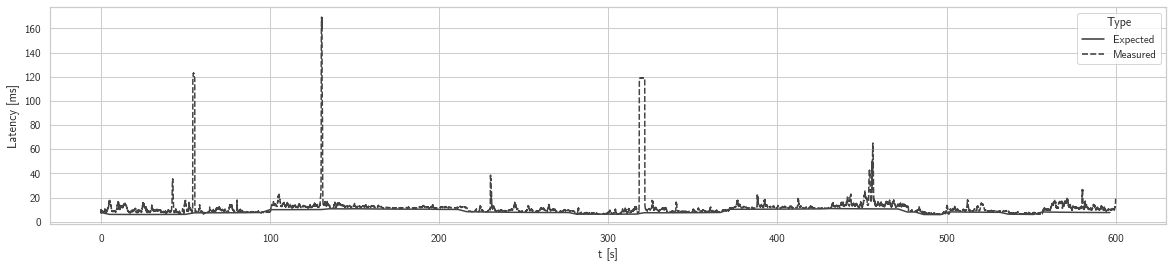

In [13]:
ax_paper = sns.lineplot(x="t", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == "satellite") & (df_paper["Run"] == "1") &(df_paper["Path"] == "3-2")], style="Type", color="#444444", ci=None)
ax_paper.set_ylabel("Latency [ms]")
ax_paper.set_xlabel("t [s]")
ax_paper

<AxesSubplot:xlabel='t', ylabel='Latency'>

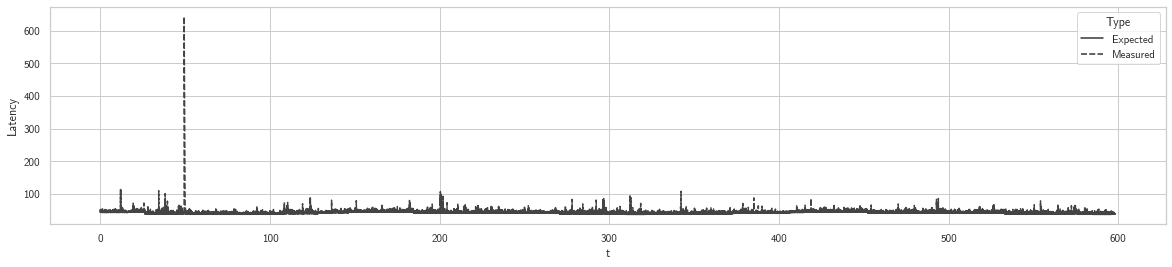

In [14]:
ax_paper = sns.lineplot(x="t", y="Latency", data=df_paper[(df_paper["Experiment"] == "server") & (df_paper["Run"] == "1") & (df_paper["Path"] == "1-3")], style="Type", color="#444444", ci=None)
ax_paper

In [19]:
sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.5, style='whitegrid', font='CMU Sans Serif')
ax_paper = sns.lineplot(x="t", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == "server") & (df_paper["Run"] == "2") & (df_paper["Path"] == "2-1")], style="Type", color="#444444", style_order=["Measured", "Expected"], ci=None)
ax_paper.set_ylabel("Latency\n(1s Rolling Median) [ms]")
ax_paper.set_xlabel("t [s]")
save_fig(ax_paper, "./paper/", "accuracy-" + "server" + "-" + "2" + "-" + "2-1", format="pdf")
sns.set(rc={'figure.figsize':(20,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')

webf NOT subset; don't know how to subset; dropped


<Figure size 720x288 with 0 Axes>

In [18]:
for experiment in ["satellite", "server"]:
    for run in ["1", "2", "3"]:
        for path in ["1-2", "1-3", "2-3", "2-1", "3-1", "3-2"]:
            ax_paper = sns.lineplot(x="t", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == experiment) & (df_paper["Run"] == run) & (df_paper["Path"] == path)], style="Type", color="#444444", style_order=["Measured", "Expected"], ci=None)
            ax_paper.set_ylabel("Latency (1s Rolling Median) [ms]")
            ax_paper.set_xlabel("t [s]")
            save_fig(ax_paper, "./website/accuracy/", "accuracy-" + experiment + "-" + run + "-" + path, format="png")


            ax_paper = sns.lineplot(x="t", y="Latency_Rolling_log10", data=df_paper[(df_paper["Experiment"] == experiment) & (df_paper["Run"] == run) & (df_paper["Path"] == path)], style="Type", color="#444444", style_order=["Measured", "Expected"], ci=None)
            ax_paper.set_ylabel("log10 Latency (1s Rolling Median) [ms]")
            ax_paper.set_xlabel("t [s]")
            save_fig(ax_paper, "./website/accuracy/", "accuracy-log10-" + experiment + "-" + run + "-" + path, format="png")

KeyboardInterrupt: 

<Figure size 1440x288 with 0 Axes>

In [17]:
for experiment in ["satellite", "server"]:
    for path in ["1-2", "1-3", "2-3", "2-1", "3-1", "3-2"]:
        for run in ["1", "2", "3"]:
            print("experiment", experiment, "path", path, "run", run, df_paper[(df_paper["Type"] == "Measured") & (df_paper["Experiment"] == experiment) & (df_paper["Run"] == run) & (df_paper["Path"] == path)]["Latency"].std())

experiment satellite path 1-2 run 1 13.295573467710385
experiment satellite path 1-2 run 2 14.018304581775263
experiment satellite path 1-2 run 3 15.283054684756623
experiment satellite path 1-3 run 1 10.449150855230096
experiment satellite path 1-3 run 2 9.286426289575314
experiment satellite path 1-3 run 3 10.641167540365899
experiment satellite path 2-3 run 1 14.554708862634698
experiment satellite path 2-3 run 2 15.413651631510913
experiment satellite path 2-3 run 3 16.51542053076207
experiment satellite path 2-1 run 1 15.268130436420872
experiment satellite path 2-1 run 2 14.457105948899681
experiment satellite path 2-1 run 3 16.713586821894697
experiment satellite path 3-1 run 1 8.795344869115995
experiment satellite path 3-1 run 2 10.028826763650532
experiment satellite path 3-1 run 3 11.947521918584723
experiment satellite path 3-2 run 1 15.935858588480071
experiment satellite path 3-2 run 2 15.37008424805261
experiment satellite path 3-2 run 3 16.67642443459107
experiment serv